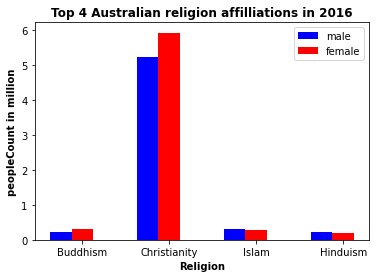

In [1]:
################################
# import all dependent libraries
################################
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import requests
from pyspark.sql.functions import explode, split, col, first
import time
from pyspark.sql.functions import udf, desc,asc,sum as Fsum
from pyspark.sql.types import (StringType, IntegerType, 
                               ArrayType,StructField, StructType)
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# agg() functions
from pyspark.sql.functions import (last,  first, max as Fmax,
                                   count, countDistinct,
                                   sum as Fsum,sumDistinct,
                                   collect_list)
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

########################################################################
# Set up a SparkSession in local mode to process datasets in a data lake
########################################################################
t0=time.time()
spark = SparkSession \
    .builder \
    .appName("ABS Census 2016 Data Analytics") \
    .config('spark.ui.port',3000) \
    .getOrCreate()
#spark.sparkContext.getConf().getAll()  # check sparksession full info

columns = StructType([
  StructField("abs_datasets", StringType(), True),
  StructField("POA", StringType(), True),
  StructField("birthCountry", StringType(), True),    
  StructField("sex", StringType(), True), 
  StructField("religion", StringType(), True), 
  StructField("count", IntegerType(), True)    
])

Dff = spark.read\
    .schema(columns)\
    .option("mode","DROPMALFORMED")\
    .csv("RELIGIONsxBCpoa.csv")
#    .csv("religion_MFbirthACTpc.csv")
Dff=Dff.withColumn("postcode",split(col("POA"),",").getItem(0))\
        .withColumn("state",split(col("POA"),",").getItem(1))\
        .drop("POA","abs_datasets").dropna()
Dff=Dff.filter(col("count") != 0)

BM=Dff.filter((col("religion")=="Buddhism") & (col("sex")=="Male"))\
         .groupBy('religion').sum("count")
BF=Dff.filter((col("religion")=="Buddhism") & (col("sex")=="Female"))\
         .groupBy('religion').sum("count")
CM=Dff.filter((col("religion")=="Christianity") & (col("sex")=="Male"))\
         .groupBy('religion').sum("count")
CF=Dff.filter((col("religion")=="Christianity") & (col("sex")=="Female"))\
         .groupBy('religion').sum("count")
IM=Dff.filter((col("religion")=="Islam") & (col("sex")=="Male"))\
         .groupBy('religion').sum("count")
IF=Dff.filter((col("religion")=="Islam") & (col("sex")=="Female"))\
         .groupBy('religion').sum("count")
HM=Dff.filter((col("religion")=="Hinduism") & (col("sex")=="Male"))\
        .groupBy('religion').sum("count")
HF=Dff.filter((col("religion")=="Hinduism") & (col("sex")=="Female"))\
        .groupBy('religion').sum("count")

# create a new dataframe in order to plot the result bar graph
# labels = StructType([\
#          StructField("religion", StringType(), True),\
#          StructField("male", IntegerType(), True),\
#          StructField("female", IntegerType(), True)
#      ])
# labels=("religion","male","female")
# data = [("Buddhism",BM.head()[1],BF.head()[1]),
#         ("Christianity",CM.head()[1],CF.head()[1]),
#         ("Islam",IM.head()[1],IF.head()[1]),
#         ("Hinduism",HM.head()[1],HF.head()[1])]
# HistDF = spark.createDataFrame(data=data, schema=labels)
# HistDF_pd = HistDF.toPandas()
labels=["religion","male","female"]
data = [["Buddhism",BM.head()[1],BF.head()[1]],
        ["Christianity",CM.head()[1],CF.head()[1]],
        ["Islam",IM.head()[1],IF.head()[1]],
        ["Hinduism",HM.head()[1],HF.head()[1]]]
HistDF_pd = pd.DataFrame(data,columns=labels)


# plot the bar graph of top 3 religion affiliations in 2016
#
# set heights of bars 
bars1 = HistDF_pd["male"]/1000000
bars2 = HistDF_pd["female"]/1000000

# set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + 0.25 for x in r1]

# make plot
plt.bar(r1,bars1,width=0.25,color='blue',label='male')
plt.bar(r2,bars2,width=0.25,color='red',label='female')
#plt.bar(HistDF_pd["religion"])
#plt.ylim(0,1.2*max(HistDF_pd["male"]))
plt.xlabel("Religion", fontweight='bold')
plt.xticks([r+0.25 for r in range(len(bars1))],\
            ["Buddhism","Christianity","Islam","Hinduism"])
plt.ylabel("peopleCount in million", fontweight='bold')
plt.title("Top 4 Australian religion affilliations in 2016", fontweight='bold')
plt.legend()
plt.show()

In [ ]:
HistDF.printSchema()
type(HistDF)
HistDF.show(truncate=False)